## Imports

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from tqdm.notebook import tqdm
sns.set_style('darkgrid')

## Data Preprocessing

In [2]:
# read data
df = pd.read_csv('data.csv')

# add datetime variable instead of 'month_name-day,year' type object
df['Date'] = pd.date_range("2010-07-13", periods=4663, freq="D")[::-1]

# set time variable as index & select data from interval [2017-01-01,2023-04-18]
df = df.set_index('Date').loc['2017-01-01':]

# sort values by time-ascending order
df = df[::-1]

# convert open-price variable from object to float
df['Open'] = df.Open.str.replace('$', '').str.replace(',', '').astype('float')

C:\Users\User\AppData\Local\Temp\ipykernel_17364\667846328.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Open'] = df.Open.str.replace('$', '').str.replace(',', '').astype('float')


In [3]:
# extract open-price historical data
X = df['Open'].values

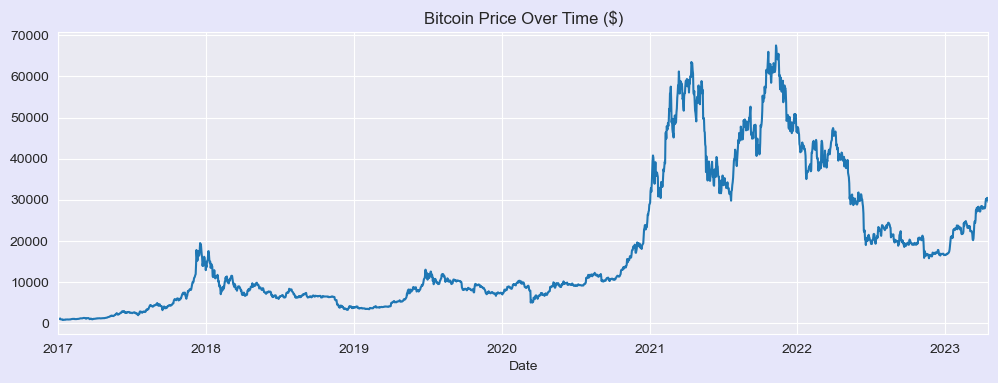

In [4]:
# vizualize bitcoin 
fig, ax = plt.subplots(figsize=(12,4), dpi=100, facecolor="lavender")
df[['Open']].plot(ax=ax)
plt.title('Bitcoin Price Over Time ($)')
plt.legend('', frameon=False);

In [5]:
# scale data 
X = X / 1000

### Generate X & y Matrices

In [6]:
# vizualize input-target pairs
n = 0
for i in range(0, df.shape[0]-30):
    print('Input:')
    print(X[i:i+30])
    print(f'Target:')
    print(X[i+30])
    print('--------------------------------------------------------------------------')
    n+=1
    if n == 2:
        break

Input:
[0.96366 0.99862 1.0216  1.0444  1.15673 1.01424 0.90349 0.90817 0.91324
 0.90244 0.90811 0.77518 0.80374 0.82514 0.81814 0.82178 0.83095 0.90937
 0.88834 0.89817 0.89555 0.92221 0.9255  0.91068 0.89192 0.9024  0.91836
 0.91981 0.92207 0.92015]
Target:
0.92096
--------------------------------------------------------------------------
Input:
[0.99862 1.0216  1.0444  1.15673 1.01424 0.90349 0.90817 0.91324 0.90244
 0.90811 0.77518 0.80374 0.82514 0.81814 0.82178 0.83095 0.90937 0.88834
 0.89817 0.89555 0.92221 0.9255  0.91068 0.89192 0.9024  0.91836 0.91981
 0.92207 0.92015 0.92096]
Target:
0.97094
--------------------------------------------------------------------------


In [7]:
# preprocess sequence into input-target pairs
X_seq, y = [], []
for i in range(0, df.shape[0]-30):
    X_seq.append(X[i:i+30])
    y.append(X[i+30])

In [8]:
# select train-validation-test splits
# last month for test and month before for validation
X_train, y_train = X_seq[:-60], y[:-60]
X_val, y_val = X_seq[-60:-30], y[-60:-30]
X_test, y_test = X_seq[-30:], y[-30:]

In [9]:
# convert lists into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [10]:
# finally convert data from numpy array to torch Tensors as I will use Pytorch for modeling
train_x, val_x, test_x = torch.Tensor(X_train), torch.Tensor(X_val), torch.Tensor(X_test)
train_y, val_y, test_y = torch.Tensor(y_train), torch.tensor(y_val), torch.Tensor(y_test)

### Define Dataset & Dataloader

In [11]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [12]:
train_dataset = MyDataset(train_x, train_y)
val_dataset = MyDataset(val_x, val_y)
test_dataset = MyDataset(test_x, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
for n, (x, y) in enumerate(train_dataloader):
    print(n)
    print(x.shape)
    print(y.shape)
    break

0
torch.Size([32, 30])
torch.Size([32])


## Modeling

### Experiment I: one layer simple LSTM

In [14]:
class lstm1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=60, num_layers=1, batch_first=True)
        self.linear = nn.Linear(60, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [15]:
model1 = lstm1()

In [16]:
summary(model1, input=torch.randn(32,30,1))

Layer (type:depth-idx)                   Param #
lstm1                                    --
├─LSTM: 1-1                              15,120
├─Linear: 1-2                            61
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0

In [18]:
# set optimizer & loss function & learning_rate_scheduler
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)

In [19]:
num_epochs = 100

In [20]:
bar_1 = tqdm(position=0, desc='epoch bar', total = num_epochs)
bar_2 = tqdm(position=1, desc='Batch bar', total = len(train_dataloader), leave=True)

train_losses_1 = []

for epoch in range(1, num_epochs+1):
    model1.train()
    train_loss = 0
    for X_batch, y_batch in train_dataloader:
        X_batch = X_batch.unsqueeze(axis=-1)
        y_pred = model1(X_batch)
        loss = loss_fn(y_pred.squeeze(axis=-1), y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bar_2.update(1)
        bar_2.set_description(f"loss:{loss.item():.2f}")

        train_loss+=loss.item()
    
    model1.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_dataloader:
            X_batch = X_batch.unsqueeze(axis=-1)
            y_pred = model1(X_batch)
            loss = loss_fn(y_pred.squeeze(axis=-1), y_batch)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Average Train MSE: {train_loss/len(train_dataloader):.3f} | Val MSE: {loss.item():.3f}")
    
    train_losses_1.append(train_loss/len(train_dataloader))
    scheduler.step(train_loss/len(train_dataloader))

    bar_1.update(1)
    bar_2.reset()

epoch bar:   0%|          | 0/100 [00:00<?, ?it/s]

Batch bar:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 10 | Average Train MSE: 1.306 | Val MSE: 0.948
Epoch 20 | Average Train MSE: 1.121 | Val MSE: 0.952
Epoch 30 | Average Train MSE: 1.149 | Val MSE: 0.605
Epoch 00030: reducing learning rate of group 0 to 1.0000e-03.
Epoch 40 | Average Train MSE: 0.879 | Val MSE: 0.551
Epoch 00046: reducing learning rate of group 0 to 1.0000e-04.
Epoch 50 | Average Train MSE: 0.858 | Val MSE: 0.565
Epoch 60 | Average Train MSE: 0.857 | Val MSE: 0.564
Epoch 70 | Average Train MSE: 0.855 | Val MSE: 0.571
Epoch 00072: reducing learning rate of group 0 to 1.0000e-05.
Epoch 80 | Average Train MSE: 0.850 | Val MSE: 0.564
Epoch 00083: reducing learning rate of group 0 to 1.0000e-06.
Epoch 90 | Average Train MSE: 0.850 | Val MSE: 0.564
Epoch 00092: reducing learning rate of group 0 to 1.0000e-07.
Epoch 100 | Average Train MSE: 0.849 | Val MSE: 0.564
Epoch 00100: reducing learning rate of group 0 to 1.0000e-08.


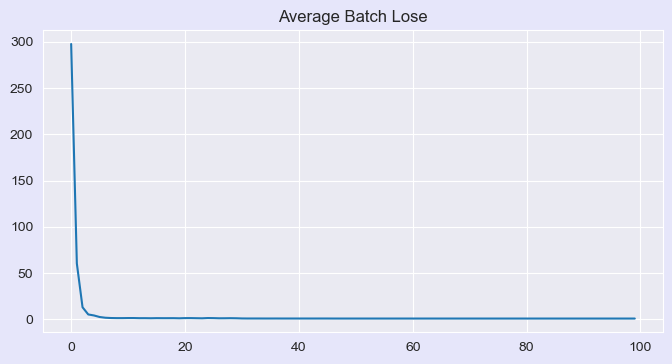

In [21]:
plt.figure(figsize=(8,4), dpi=100, facecolor="lavender")
plt.plot([*range(100)],train_losses_1)
plt.title('Average Batch Lose');

In [55]:
for X_batch, y_batch in val_dataloader:
    break

In [58]:
model1.eval()
with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        X_batch = X_batch.unsqueeze(axis=-1)
        pred = model1(X_batch)
        loss = loss_fn(pred.squeeze(axis=-1), y_batch)

In [59]:
df['Pred1'] = np.nan
df.iloc[-30:,-1] = pred * 1000

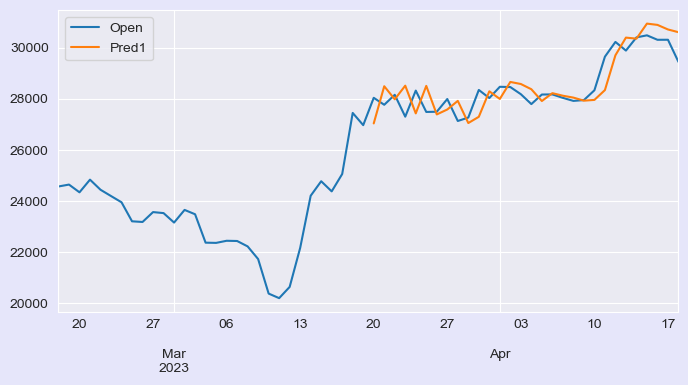

In [64]:
fig, ax = plt.subplots(figsize=(8,4), dpi=100, facecolor="lavender")

df.iloc[-60:][['Open', 'Pred1']].plot(ax=ax)
plt.xlabel(None);

In [66]:
torch.save(model1.state_dict(), 'weights/lstm1.pt')

### Experiment II: double reccurent layer LSTM

In [74]:
class lstm2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=60, num_layers=2, batch_first=True)
        self.linear = nn.Linear(60, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [82]:
model2 = lstm2()

In [83]:
summary(model2, input=torch.randn(32,30,1))

Layer (type:depth-idx)                   Param #
lstm2                                    --
├─LSTM: 1-1                              44,400
├─Linear: 1-2                            61
Total params: 44,461
Trainable params: 44,461
Non-trainable params: 0

In [84]:
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)

In [85]:
bar_1 = tqdm(position=0, desc='epoch bar', total = num_epochs)
bar_2 = tqdm(position=1, desc='Batch bar', total = len(train_dataloader), leave=True)

train_losses_2 = []

for epoch in range(1, num_epochs+1):
    model2.train()
    train_loss = 0
    for X_batch, y_batch in train_dataloader:
        X_batch = X_batch.unsqueeze(axis=-1)
        y_pred = model2(X_batch)
        loss = loss_fn(y_pred.squeeze(axis=-1), y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bar_2.update(1)
        bar_2.set_description(f"loss:{loss.item():.2f}")

        train_loss+=loss.item()
    
    model2.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_dataloader:
            X_batch = X_batch.unsqueeze(axis=-1)
            y_pred = model1(X_batch)
            loss = loss_fn(y_pred.squeeze(axis=-1), y_batch)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Average Train MSE: {train_loss/len(train_dataloader):.3f} | Val MSE: {loss.item():.3f}")
    
    train_losses_2.append(train_loss/len(train_dataloader))
    scheduler.step(train_loss/len(train_dataloader))

    bar_1.update(1)
    bar_2.reset()

epoch bar:   0%|          | 0/100 [00:00<?, ?it/s]

Batch bar:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 10 | Average Train MSE: 6.141 | Val MSE: 0.564
Epoch 20 | Average Train MSE: 1.795 | Val MSE: 0.564
Epoch 30 | Average Train MSE: 1.500 | Val MSE: 0.564
Epoch 00031: reducing learning rate of group 0 to 1.0000e-03.
Epoch 40 | Average Train MSE: 0.916 | Val MSE: 0.564
Epoch 00044: reducing learning rate of group 0 to 1.0000e-04.
Epoch 50 | Average Train MSE: 1.050 | Val MSE: 0.564
Epoch 00052: reducing learning rate of group 0 to 1.0000e-05.
Epoch 60 | Average Train MSE: 0.871 | Val MSE: 0.564
Epoch 00069: reducing learning rate of group 0 to 1.0000e-06.
Epoch 70 | Average Train MSE: 0.869 | Val MSE: 0.564
Epoch 80 | Average Train MSE: 0.870 | Val MSE: 0.564
Epoch 00080: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00087: reducing learning rate of group 0 to 1.0000e-08.
Epoch 90 | Average Train MSE: 1.047 | Val MSE: 0.564
Epoch 100 | Average Train MSE: 0.889 | Val MSE: 0.564


In [86]:
model2.eval()
with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        X_batch = X_batch.unsqueeze(axis=-1)
        pred = model2(X_batch)
        loss = loss_fn(pred.squeeze(axis=-1), y_batch)

In [87]:
df['Pred2'] = np.nan
df.iloc[-30:,-1] = pred * 1000

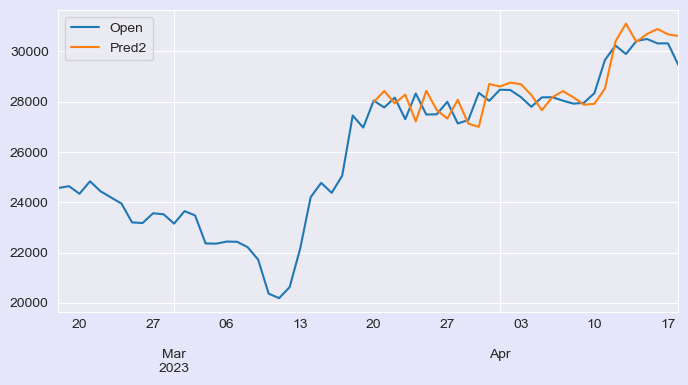

In [88]:
fig, ax = plt.subplots(figsize=(8,4), dpi=100, facecolor="lavender")

df.iloc[-60:][['Open', 'Pred2']].plot(ax=ax)
plt.xlabel(None);

In [93]:
torch.save(model2.state_dict(), 'weights/lstm2.pt')

### Experiment IIi: bidirectional LSTM

In [116]:
class lstm3(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=60, num_layers=1, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(120, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [117]:
model3 = lstm3()
summary(model3, input=torch.randn(32,30,1))

Layer (type:depth-idx)                   Param #
lstm3                                    --
├─LSTM: 1-1                              30,240
├─Linear: 1-2                            121
Total params: 30,361
Trainable params: 30,361
Non-trainable params: 0

In [118]:
optimizer = torch.optim.Adam(model3.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)

In [121]:
bar_1 = tqdm(position=0, desc='epoch bar', total = num_epochs)
bar_2 = tqdm(position=1, desc='Batch bar', total = len(train_dataloader), leave=True)

train_losses_3 = []

for epoch in range(1, num_epochs+1):
    model3.train()
    train_loss = 0
    for X_batch, y_batch in train_dataloader:
        X_batch = X_batch.unsqueeze(axis=-1)
        y_pred = model3(X_batch)
        loss = loss_fn(y_pred.squeeze(axis=-1), y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bar_2.update(1)
        bar_2.set_description(f"loss:{loss.item():.2f}")

        train_loss+=loss.item()
    
    model3.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_dataloader:
            X_batch = X_batch.unsqueeze(axis=-1)
            y_pred = model3(X_batch)
            loss = loss_fn(y_pred.squeeze(axis=-1), y_batch)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Average Train MSE: {train_loss/len(train_dataloader):.3f} | Val MSE: {loss.item():.3f}")
    
    train_losses_3.append(train_loss/len(train_dataloader))
    scheduler.step(train_loss/len(train_dataloader))

    bar_1.update(1)
    bar_2.reset()

epoch bar:   0%|          | 0/100 [00:00<?, ?it/s]

Batch bar:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 10 | Average Train MSE: 1.226 | Val MSE: 0.706
Epoch 20 | Average Train MSE: 1.207 | Val MSE: 1.686
Epoch 00020: reducing learning rate of group 0 to 1.0000e-03.
Epoch 30 | Average Train MSE: 0.919 | Val MSE: 0.653
Epoch 00035: reducing learning rate of group 0 to 1.0000e-04.
Epoch 40 | Average Train MSE: 0.874 | Val MSE: 0.650
Epoch 50 | Average Train MSE: 0.866 | Val MSE: 0.680
Epoch 00053: reducing learning rate of group 0 to 1.0000e-05.
Epoch 60 | Average Train MSE: 0.862 | Val MSE: 0.660
Epoch 00065: reducing learning rate of group 0 to 1.0000e-06.
Epoch 70 | Average Train MSE: 0.862 | Val MSE: 0.659
Epoch 00072: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00079: reducing learning rate of group 0 to 1.0000e-08.
Epoch 80 | Average Train MSE: 0.862 | Val MSE: 0.660
Epoch 90 | Average Train MSE: 0.879 | Val MSE: 0.660
Epoch 100 | Average Train MSE: 0.863 | Val MSE: 0.660


In [122]:
model3.eval()
with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        X_batch = X_batch.unsqueeze(axis=-1)
        pred = model3(X_batch)
        loss = loss_fn(pred.squeeze(axis=-1), y_batch)

In [123]:
df['Pred3'] = np.nan
df.iloc[-30:,-1] = pred * 1000

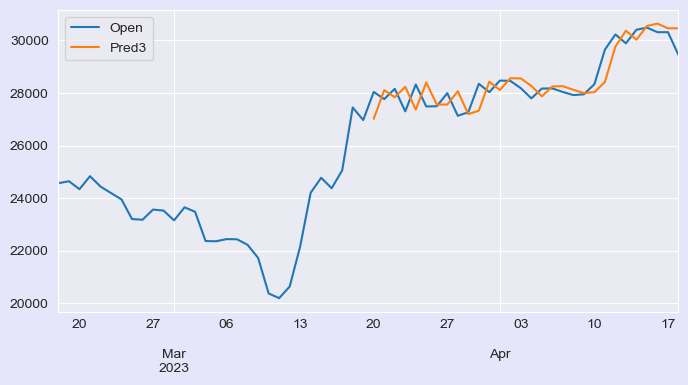

In [124]:
fig, ax = plt.subplots(figsize=(8,4), dpi=100, facecolor="lavender")

df.iloc[-60:][['Open', 'Pred3']].plot(ax=ax)
plt.xlabel(None);

In [125]:
torch.save(model3.state_dict(), 'weights/lstm3.pt')

### Compare Models

#### Vizualization

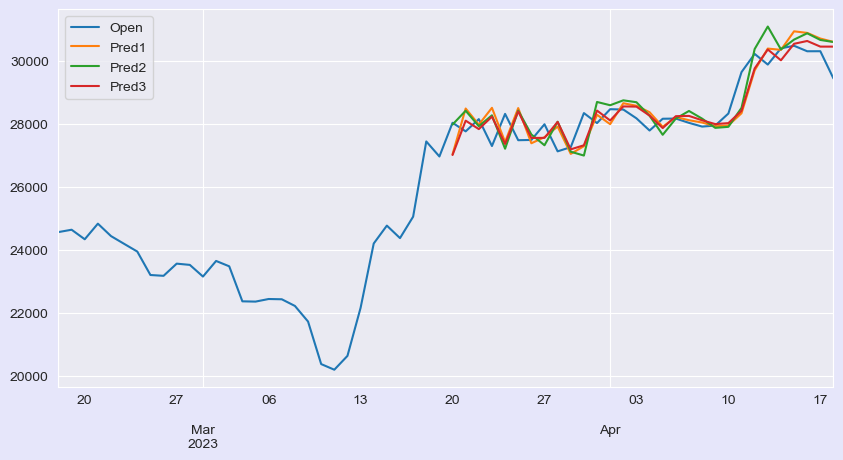

In [128]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100, facecolor="lavender")

df.iloc[-60:][['Open', 'Pred1', 'Pred2', 'Pred3']].plot(ax=ax)
plt.xlabel(None)
plt.savefig("figure.png", dpi=300);

#### Metrics

In [143]:
def RMSE(y, y_pred):
    return np.sqrt(np.mean((y - y_pred) ** 2))

def RMSLE(y, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y))))

def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [144]:
preds_df = df.iloc[-30:]

In [145]:
pd.DataFrame({'RMSE': [RMSE(preds_df.Open, preds_df.Pred1), RMSE(preds_df.Open, preds_df.Pred2), RMSE(preds_df.Open, preds_df.Pred3)],
              'RMSLE': [RMSLE(preds_df.Open, preds_df.Pred1), RMSLE(preds_df.Open, preds_df.Pred2), RMSLE(preds_df.Open, preds_df.Pred3)],
              'MAE': [MAE(preds_df.Open, preds_df.Pred1), MAE(preds_df.Open, preds_df.Pred2), MAE(preds_df.Open, preds_df.Pred3)]},
               index=['Simple LSTM', 'Double-stacked LSTM', 'Bidirectional LSTM'])

,RMSE,RMSLE,MAE
Simple LSTM,638.516309,0.022422,514.931917
Double-stacked LSTM,660.138582,0.023128,526.016206
Bidirectional LSTM,583.562107,0.020594,465.586776
